In [1]:
# Import necessary packages
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
import seaborn as sns
import glob
import scipy.io
import pandas as pd

from mpl_point_clicker import clicker
from scipy.optimize import curve_fit
from skimage.filters.rank import gradient
from skimage.morphology import ball
from io import StringIO

sns.set()
%matplotlib inline

In [3]:
# Define functions for importing images and curve fitting

def import_image(file_path, dapi_ch = 0, slug_ch = 1, pax_ch = 2, filter_size = 1.5):
    '''
    Takes a file path for mapped image, indices of channels and size for gradient filter. 
    file_path: str with path to mapped images
    dapi_ch: Index of DAPI channel within file_path
    slug_ch: Index of Slug channel
    pax_ch: Index of pax3 channel
    filter_size: Kernel size of ball for gradient filter of image
    '''
    
    # Import individual mapped channels
    dapi = skimage.io.imread(sorted(glob.glob(file_path))[dapi_ch])
    slug = skimage.io.imread(sorted(glob.glob(file_path))[slug_ch])
    pax = skimage.io.imread(sorted(glob.glob(file_path))[pax_ch])
    
    # Select z-slices corresponding to deep cell layer
    dapi = dapi[2:14,:,:]
    slug = slug[2:14,:,:]
    pax = pax[2:14,:,:]
    
    # Apply smoothing filters to HCR channels
    slug_grad = gradient(slug, ball(1.5))
    pax_grad = gradient(pax, ball(1.5))
    
    return (dapi, slug_grad, pax_grad)

def measure_line_profile(im, medial_ant, lateral_ant, medial_post, lateral_post, width = 21):
    '''
    Takes an image and medial/lateral start and end points, measures line profile and normalizes
    im: Image to measure intensities
    medial_ant: Coordinates of medial/anterior point
    lateral_ant: Coordinates of lateral/anterior point
    medial_post: Coordinates of medial/posterior point
    lateral_post: Coordinates of lateral/posterior point
    width: Width of line profile
    '''
    # Measure line profiles
    im_profile_ant = skimage.measure.profile_line(np.mean(im,axis=0).T, src=medial_ant, dst=lateral_ant, linewidth=width)
    im_profile_post = skimage.measure.profile_line(np.mean(im,axis=0).T, src=medial_post, dst=lateral_post, linewidth=width)
    
    # Normalize to 0 and 1
    #im_max = np.max(np.concatenate((im_profile_ant, im_profile_post)))
    im_max = np.percentile(np.concatenate((im_profile_ant, im_profile_post)), 99)
    im_min = np.min(np.concatenate((im_profile_ant, im_profile_post)))
    
    im_profile_ant = (im_profile_ant - im_min) / (im_max - im_min)
    im_profile_post = (im_profile_post - im_min) / (im_max - im_min)
    
    return im_profile_ant, im_profile_post
    

def exp_fit(x, a, b, k):
    '''
    Define sigmoid function to fit line profile data
    Fits the function k*e^(-((x-a)/b)**2)
    '''
    return (k * np.exp(-((x-a)/b)**2))

def avg_curves(curve_list_y, curve_list_x):
    '''
    Averages curves of different lengths for comparing line profiles. 
    Assumes x-values of curves are centered on 0 
    curve_list_y: List of line profile intensities
    curve_list_x: List of line profile pixel locations, with peak on 0 after curve fitting
    '''
    # Find intersection of x-values
    x_lim = curve_list_x[0]
    for curve_num in range(len(curve_list_x)):
        x_lim = np.intersect1d(x_lim, curve_list_x[curve_num])
        
    print(len(x_lim))
    new_curve_list = []
    
    # Filter y-ranges based on x_lim
    for curve_num in range(len(curve_list_y)):
        new_curve = curve_list_y[curve_num]
        new_curve = new_curve[np.where(np.isin(curve_list_x[curve_num], x_lim) == True)[0]]
        new_curve_list.append(new_curve)
     
    # Compute average and standard error
    avg_curve = np.mean(new_curve_list, axis=0)
    std_error = np.std(new_curve_list, axis=0) #/ np.sqrt(len(curve_list_y))
        
    return x_lim, avg_curve, std_error
        

In [4]:
# Define empty lists for data storage - ONLY RUN THIS CELL ONCE PER EXPERIMENT
# Stores Image file paths 
file_paths = []

# Stores pixel ranges for anterior and posterior line profiles
x_range_ant = []
x_range_post = []

# Stores intensity measurements for anterior and posterior line profiles
slug_ant_list = []
slug_post_list = []
pax3_post_list = []
pax3_ant_list = []

# Stores start/end points for line profiles
ant_click_list = []
post_click_list = []

Leave a few cells blank where the analysis for each image starts.

In [8]:
# Check file path
im_num = '002' 
file_path = '../raw_data/pax_slug_stg15/rep2/*'+str(im_num)+'*/projectFiles/mapping/*.tif'
sorted(glob.glob(file_path))

['../raw_data/pax_slug_stg15/rep2/2023_09_29_pax3_b2_546_slug_b3_647_stg_15_10x_002.nd2_1/projectFiles/mapping/xy_stack_C1_T1.tif',
 '../raw_data/pax_slug_stg15/rep2/2023_09_29_pax3_b2_546_slug_b3_647_stg_15_10x_002.nd2_1/projectFiles/mapping/xy_stack_C2_T1.tif',
 '../raw_data/pax_slug_stg15/rep2/2023_09_29_pax3_b2_546_slug_b3_647_stg_15_10x_002.nd2_1/projectFiles/mapping/xy_stack_C3_T1.tif']

/opt/anaconda3/lib/python3.12/site-packages/skimage/filters/rank/generic.py:353: UserWarning: Bad rank filter performance is expected due to a large number of bins (2304), equivalent to an approximate bitdepth of 11.2.
  image, footprint, out, mask, n_bins = _handle_input_3D(
/opt/anaconda3/lib/python3.12/site-packages/skimage/filters/rank/generic.py:353: UserWarning: Bad rank filter performance is expected due to a large number of bins (1580), equivalent to an approximate bitdepth of 10.6.
  image, footprint, out, mask, n_bins = _handle_input_3D(


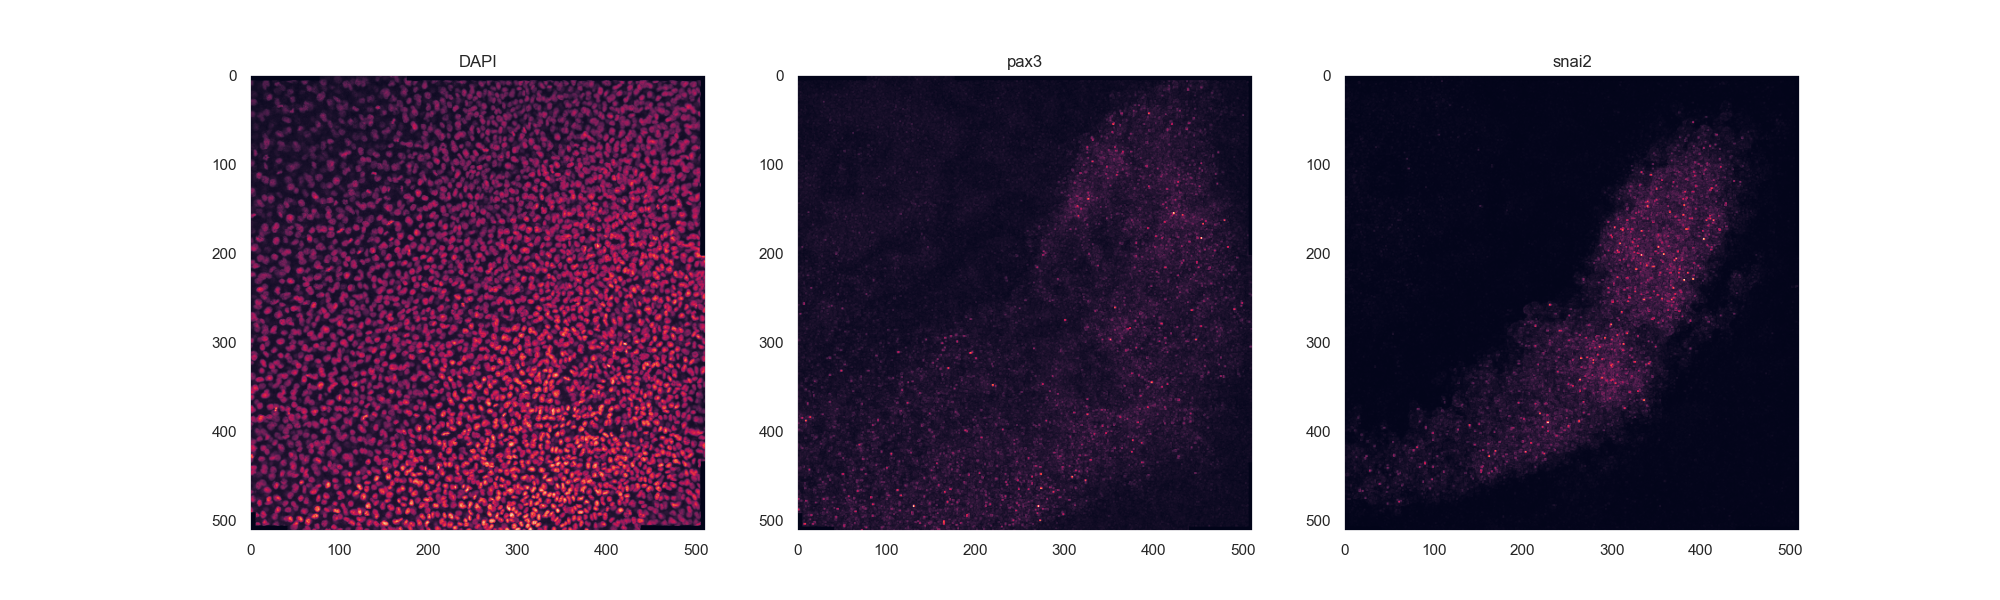

In [9]:
# Import image
dapi, slug, pax3 = import_image(file_path, dapi_ch=0, slug_ch=2, pax_ch=1, filter_size=3)

# View channels
fig, ax = plt.subplots(1,3, figsize=(20,6))

ax[0].imshow(np.amax(dapi, axis=0))
ax[1].imshow(np.amax(pax3, axis=0))
ax[2].imshow(np.amax(slug, axis=0))

ax[0].set_title("DAPI")
ax[1].set_title("pax3")
ax[2].set_title("snai2")

for axis in ax:
    axis.grid(False)

plt.show()

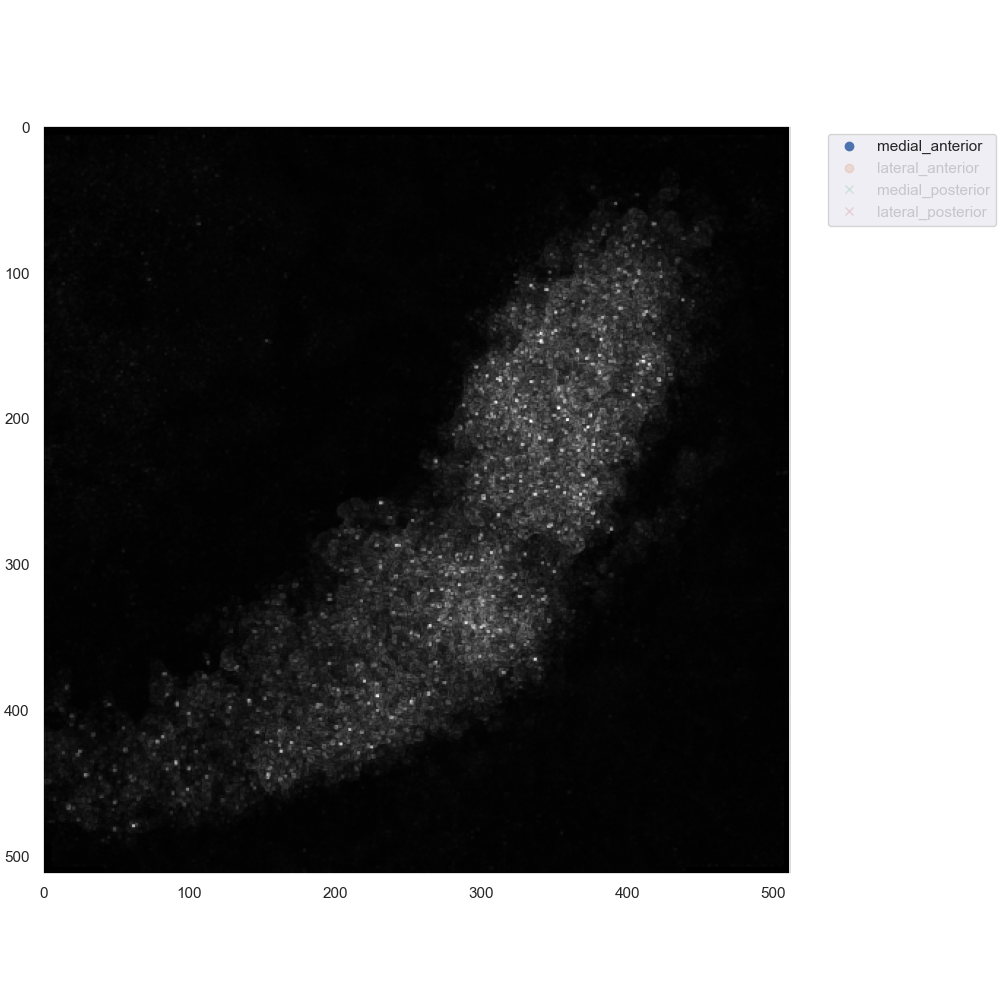

In [10]:
# Select points for measuring line profiles 

%matplotlib ipympl

fig, ax = plt.subplots(figsize=(10,10), constrained_layout=True)
image = np.mean(slug, axis=0)
ax.grid(False)
ax.imshow(image, cmap="gray", vmax=800)

klicker = clicker(
   ax,
   ["medial_anterior", "lateral_anterior", "medial_posterior", "lateral_posterior"],
   markers=["o","o","x","x"]
)

In [39]:
# Retrieve selected points
ma = klicker.get_positions().get('medial_anterior')
la = klicker.get_positions().get('lateral_anterior')

mp = klicker.get_positions().get('medial_posterior')
lp = klicker.get_positions().get('lateral_posterior')

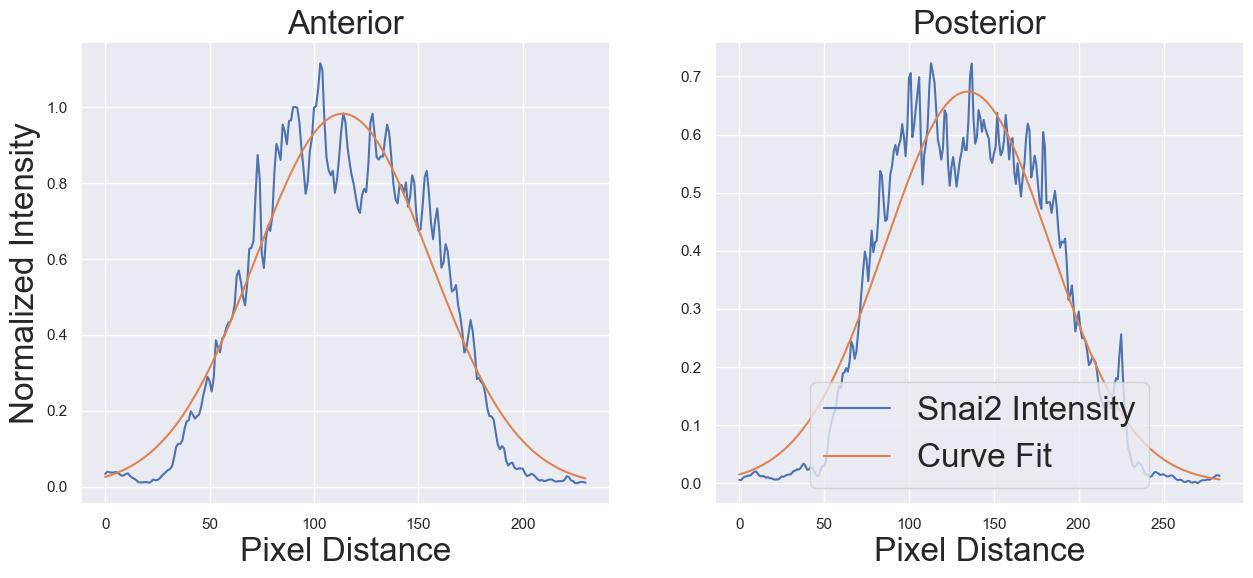

In [41]:
# Measure line profiles
pax3_ant, pax3_post = measure_line_profile(pax3, ma[0], la[0], mp[0], lp[0], width=51)
slug_ant, slug_post = measure_line_profile(slug, ma[0], la[0], mp[0], lp[0], width=51)

# Fit exponential to slug profile
x_ant = np.arange(len(slug_ant))
y_ant = slug_ant

x_post = np.arange(len(slug_post))
y_post = slug_post

# Fit and plot curve to line profile
popt_ant, pcov_ant = curve_fit(exp_fit, x_ant, y_ant, p0 = [100, 10, 1])
popt_post, pcov_post = curve_fit(exp_fit, x_post, y_post, p0 = [100, 10, 1])


%matplotlib inline

fig, ax = plt.subplots(1,2, figsize=(15,6))

ax[0].plot(x_ant, slug_ant)
ax[0].plot(x_ant, exp_fit(x_ant, popt_ant[0], popt_ant[1], popt_ant[2]))

ax[1].plot(x_post, slug_post)
ax[1].plot(x_post, exp_fit(x_post, popt_post[0], popt_post[1], popt_post[2]))

ax[0].set_title('Anterior', fontsize=24)
ax[1].set_title('Posterior', fontsize=24)
ax[0].set_xlabel('Pixel Distance', fontsize=24)
ax[1].set_xlabel('Pixel Distance', fontsize=24)

ax[0].set_ylabel('Normalized Intensity', fontsize=24)

ax[1].legend(['Snai2 Intensity', 'Curve Fit'], fontsize=24, loc='lower center')

plt.show()
#plt.savefig('snai2_curve_fit.png', dpi=300, bbox='tight')

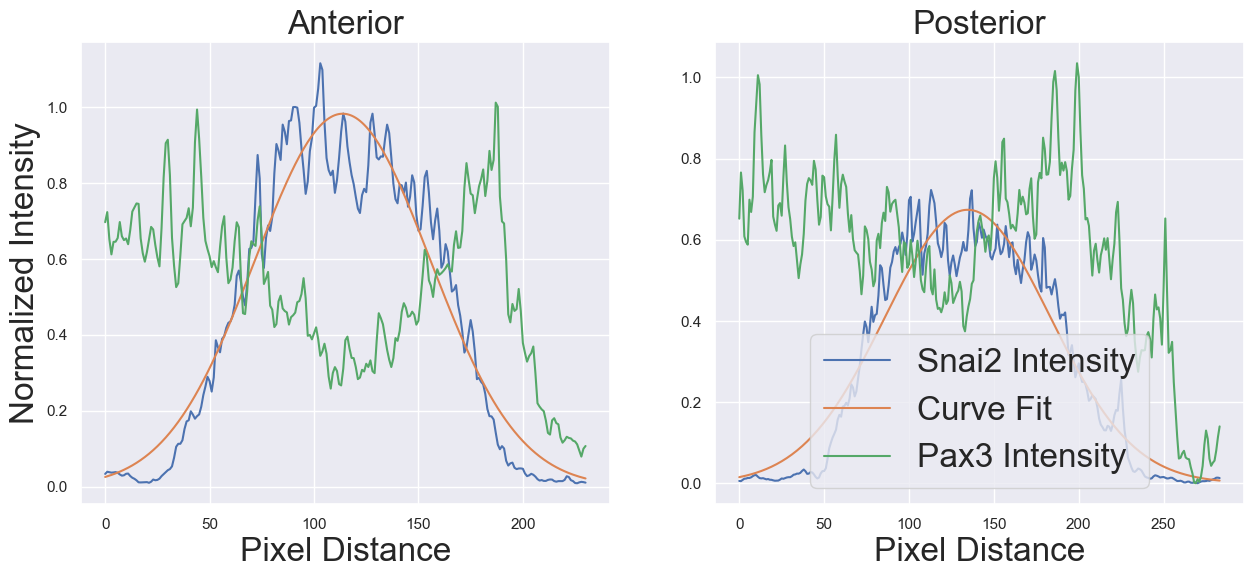

In [42]:
fig, ax = plt.subplots(1,2, figsize=(15,6))

ax[0].plot(x_ant, slug_ant)
ax[0].plot(x_ant, exp_fit(x_ant, popt_ant[0], popt_ant[1], popt_ant[2]))
ax[0].plot(x_ant, pax3_ant)


ax[1].plot(x_post, slug_post)
ax[1].plot(x_post, exp_fit(x_post, popt_post[0], popt_post[1], popt_post[2]))
ax[1].plot(x_post, pax3_post)


ax[0].set_title('Anterior', fontsize=24)
ax[1].set_title('Posterior', fontsize=24)
ax[0].set_xlabel('Pixel Distance', fontsize=24)
ax[1].set_xlabel('Pixel Distance', fontsize=24)

ax[0].set_ylabel('Normalized Intensity', fontsize=24)

ax[1].legend(['Snai2 Intensity', 'Curve Fit', 'Pax3 Intensity'], fontsize=24, loc='lower center')

plt.show()

#plt.savefig('snai2_pax3_curve_fit.png', dpi=300, bbox='tight')

In [43]:
# Save data for this embryo
file_paths.append(file_path)

x_range_ant.append(x_ant - int(popt_ant[0]))
x_range_post.append(x_post - int(popt_post[0]))

slug_ant_list.append(slug_ant)
slug_post_list.append(slug_post)
pax3_post_list.append(pax3_post)
pax3_ant_list.append(pax3_ant)

ant_click_list.append(tuple((ma, la)))
post_click_list.append(tuple((mp,lp)))

In [44]:
# Average curves and compute standard error
slug_ant_x, slug_ant_y, slug_ant_error = avg_curves(slug_ant_list, x_range_ant)
slug_post_x, slug_post_y, slug_post_error = avg_curves(slug_post_list, x_range_post)

pax3_ant_x, pax3_ant_y, pax3_ant_error = avg_curves(pax3_ant_list, x_range_ant)
pax3_post_x, pax3_post_y, pax3_post_error = avg_curves(pax3_post_list, x_range_post)

226
254
226
254


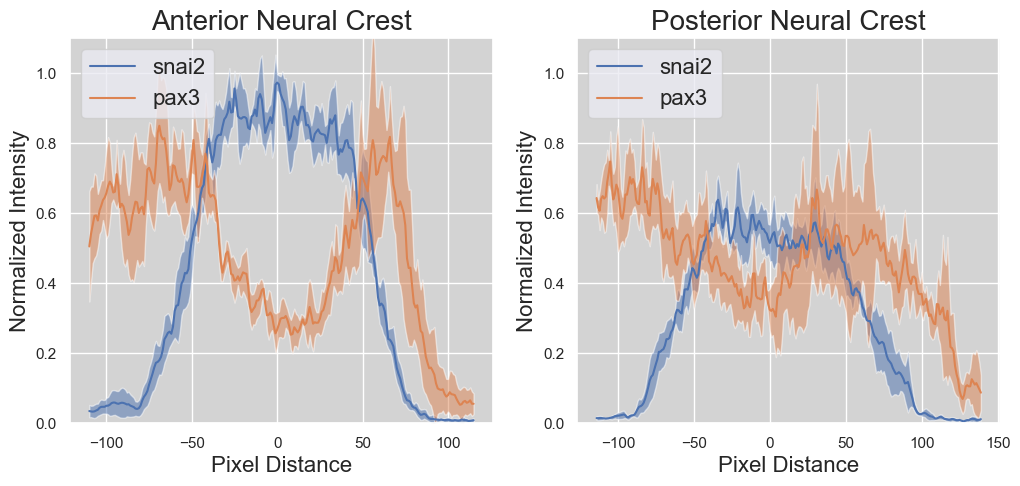

In [45]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

ax[0].plot(slug_ant_x, slug_ant_y)
ax[1].plot(slug_post_x, slug_post_y)

ax[0].fill_between(slug_ant_x, slug_ant_y+slug_ant_error, slug_ant_y-slug_ant_error, alpha=0.5, label='_nolegend_')
ax[1].fill_between(slug_post_x, slug_post_y+slug_post_error, slug_post_y-slug_post_error, alpha=0.5, label='_nolegend_')


ax[0].plot(pax3_ant_x, pax3_ant_y)
ax[1].plot(pax3_post_x, pax3_post_y)

ax[0].fill_between(pax3_ant_x, pax3_ant_y+pax3_ant_error, pax3_ant_y-pax3_ant_error, alpha=0.5, label='_nolegend_')
ax[1].fill_between(pax3_post_x, pax3_post_y+pax3_post_error, pax3_post_y-pax3_post_error, alpha=0.5, label='_nolegend_')

#for rep in range(len(slug_ant_list)):
    #ax[0].plot(x_range_ant[rep], slug_ant_list[rep], alpha=0.2, color='b')

ax[0].set_ylim(0,1.1)
ax[1].set_ylim(0,1.1)

ax[0].set_title('Anterior Neural Crest', fontsize=20)
ax[1].set_title('Posterior Neural Crest', fontsize=20)

ax[0].set_facecolor('#D3D3D3')
ax[1].set_facecolor('#D3D3D3')

ax[0].set_xlabel('Pixel Distance', fontsize=16)
ax[1].set_xlabel('Pixel Distance', fontsize=16)

ax[0].set_ylabel('Normalized Intensity', fontsize=16)
ax[1].set_ylabel('Normalized Intensity', fontsize=16)

ax[0].legend(['snai2', 'pax3'], loc='upper left', fontsize=16)
ax[1].legend(['snai2', 'pax3'], loc='upper left', fontsize=16)

plt.show()

#plt.savefig('2023_07_28_pax_slug_line_profiles.png', dpi=300, bbox='tight', transparent=True)

Run these next cells to save the data after analyzing each image in the experiment

In [48]:
# Turn data into Pandas dataframe
pax_slug_lineprofile_rep2 = pd.DataFrame({'file_paths': file_paths,
                                                     'x_range_ant': x_range_ant,
                                                     'x_range_post': x_range_post,
                                                     'slug_ant_list': slug_ant_list,
                                                     'slug_post_list': slug_post_list,
                                                     'pax3_ant_list': pax3_ant_list,
                                                     'pax3_post_list': pax3_post_list,
                                                     'ant_click_list': ant_click_list,
                                                     'post_click_list': post_click_list
                                                    })

In [50]:
# Save dataframe as pickle
pax_slug_lineprofile_rep2.to_pickle('pax_slug_lineprofile_rep2')

In [3]:
# After saving dataframes from all 3 reps, import pickle data
pax_slug_rep1 = pd.read_pickle('pax_slug_lineprofile_rep1')
pax_slug_rep2 = pd.read_pickle('pax_slug_lineprofile_rep2')
pax_slug_rep3 = pd.read_pickle('pax_slug_lineprofile_rep3')

In [4]:
# Merge data from three replicates
pax_slug_data = pd.concat([pax_slug_rep1, pax_slug_rep2, pax_slug_rep3], ignore_index=True)
pax_slug_data

Unnamed: 0                                         file_paths embryo_side  \
0            0  /Volumes/LabonneLab2/phd/Images/2022_Fall/2022...           L   
1            1  /Volumes/LabonneLab2/phd/Images/2022_Fall/2022...           L   
2            2  /Volumes/LabonneLab2/phd/Images/2022_Fall/2022...           R   
3            0  /Volumes/LabonneLab2/phd/Images/2023_Summer/20...           L   
4            1  /Volumes/LabonneLab2/phd/Images/2023_Summer/20...           L   
5            2  /Volumes/LabonneLab2/phd/Images/2023_Summer/20...           R   
6            3  /Volumes/LabonneLab2/phd/Images/2023_Summer/20...           L   
7            4  /Volumes/LabonneLab2/phd/Images/2023_Summer/20...           L   
8            0  /Volumes/LabonneLab2/phd/Images/2023_Fall/2023...           L   
9            1  /Volumes/LabonneLab2/phd/Images/2023_Fall/2023...           R   
10           2  /Volumes/LabonneLab2/phd/Images/2023_Fall/2023...           R   
11           3  /Volumes/LabonneLab2/phd/Images/2023_Fall/2023...           R   

                                          x_range_ant  \
0   [-108 -107 -106 -105 -104 -103 -102 -101 -100 ...   
1   [-103 -102 -101 -100  -99  -98  -97  -96  -95 ...   
2   [-117 -116 -115 -114 -113 -112 -111 -110 -109 ...   
3   [-104 -103 -102 -101 -100  -99  -98  -97  -96 ...   
4   [-113 -112 -111 -110 -109 -108 -107 -106 -105 ...   
5   [-113 -112 -111 -110 -109 -108 -107 -106 -105 ...   
6   [-121 -120 -119 -118 -117 -116 -115 -114 -113 ...   
7   [-100  -99  -98  -97  -96  -95  -94  -93  -92 ...   
8   [-90 -89 -88 -87 -86 -85 -84 -83 -82 -81 -80 -...   
9   [-111 -110 -109 -108 -107 -106 -105 -104 -103 ...   
10  [-92 -91 -90 -89 -88 -87 -86 -85 -84 -83 -82 -...   
11  [-103 -102 -101 -100  -99  -98  -97  -96  -95 ...   

                                         x_range_post  \
0   [-143 -142 -141 -140 -139 -138 -137 -136 -135 ...   
1   [-141 -140 -139 -138 -137 -136 -135 -134 -133 ...   
2   [-137 -136 -135 -134 -133 -132 -131 -130 -129 ...   
3   [-128 -127 -126 -125 -124 -123 -122 -121 -120 ...   
4   [-126 -125 -124 -123 -122 -121 -120 -119 -118 ...   
5   [-126 -125 -124 -123 -122 -121 -120 -119 -118 ...   
6   [-119 -118 -117 -116 -115 -114 -113 -112 -111 ...   
7   [-111 -110 -109 -108 -107 -106 -105 -104 -103 ...   
8   [-108 -107 -106 -105 -104 -103 -102 -101 -100 ...   
9   [-112 -111 -110 -109 -108 -107 -106 -105 -104 ...   
10  [-105 -104 -103 -102 -101 -100  -99  -98  -97 ...   
11  [-140 -139 -138 -137 -136 -135 -134 -133 -132 ...   

                                        slug_ant_list  \
0   [0.05077923 0.03724647 0.02522589 0.01839155 0...   
1   [0.04795144 0.05482765 0.04852893 0.0392145  0...   
2   [0.04920575 0.04550218 0.03852324 0.03043209 0...   
3   [0.04250665 0.04315724 0.04625319 0.05042907 0...   
4   [0.10014552 0.09983306 0.10783749 0.10303561 0...   
5   [0.00799085 0.01496092 0.0114619  0.01481006 0...   
6   [1.34341733e-04 0.00000000e+00 1.57452044e-03 ...   
7   [3.39150956e-02 2.53415751e-02 2.54205764e-02 ...   
8   [5.90894253e-02 5.54998634e-02 4.01481725e-02 ...   
9   [0.00940042 0.00638551 0.00783106 0.01103003 0...   
10  [0.05583635 0.06065602 0.05921407 0.04460174 0...   
11  [0.06921504 0.06903474 0.06039737 0.05767935 0...   

                                       slug_post_list  \
0   [4.32051032e-03 4.41763001e-03 2.99976023e-03 ...   
1   [8.89393504e-03 8.32229834e-03 8.41193836e-03 ...   
2   [0.02570849 0.02107664 0.01837609 0.01596563 0...   
3   [0.03270487 0.03781806 0.0348155  0.04099953 0...   
4   [0.00672503 0.00778112 0.00204907 0.00208422 0...   
5   [0.01546627 0.00222199 0.00354701 0.01092926 0...   
6   [0.01243391 0.00871637 0.01070943 0.01212237 0...   
7   [0.02350129 0.02491884 0.02804404 0.02661726 0...   
8   [5.74213401e-03 8.85310208e-03 9.28614833e-03 ...   
9   [0.0056048  0.00562467 0.00552608 0.00658463 0...   
10  [4.58895077e-03 5.16332710e-03 5.77401899e-03 ...   
11  [5.76297761e-03 6.90442962e-03 5.250

In [7]:
# Average curves and compute standard error
slug_ant_x, slug_ant_y, slug_ant_error = avg_curves(pax_slug_data['slug_ant_list'], pax_slug_data['x_range_ant'])
slug_post_x, slug_post_y, slug_post_error = avg_curves(pax_slug_data['slug_post_list'], pax_slug_data['x_range_post'])

pax3_ant_x, pax3_ant_y, pax3_ant_error = avg_curves(pax_slug_data['pax3_ant_list'], pax_slug_data['x_range_ant'])
pax3_post_x, pax3_post_y, pax3_post_error = avg_curves(pax_slug_data['pax3_post_list'], pax_slug_data['x_range_post'])

190
218
190
218


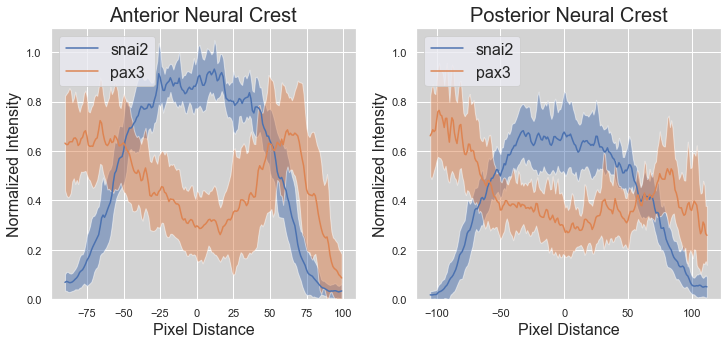

In [8]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

ax[0].plot(slug_ant_x, slug_ant_y)
ax[1].plot(slug_post_x, slug_post_y)

ax[0].fill_between(slug_ant_x, slug_ant_y+slug_ant_error, slug_ant_y-slug_ant_error, alpha=0.5, label='_nolegend_')
ax[1].fill_between(slug_post_x, slug_post_y+slug_post_error, slug_post_y-slug_post_error, alpha=0.5, label='_nolegend_')


ax[0].plot(pax3_ant_x, pax3_ant_y)
ax[1].plot(pax3_post_x, pax3_post_y)

ax[0].fill_between(pax3_ant_x, pax3_ant_y+pax3_ant_error, pax3_ant_y-pax3_ant_error, alpha=0.5, label='_nolegend_')
ax[1].fill_between(pax3_post_x, pax3_post_y+pax3_post_error, pax3_post_y-pax3_post_error, alpha=0.5, label='_nolegend_')

#for rep in range(len(slug_ant_list)):
    #ax[0].plot(x_range_ant[rep], slug_ant_list[rep], alpha=0.2, color='b')

ax[0].set_ylim(0,1.1)
ax[1].set_ylim(0,1.1)

ax[0].set_title('Anterior Neural Crest', fontsize=20)
ax[1].set_title('Posterior Neural Crest', fontsize=20)

ax[0].set_facecolor('#D3D3D3')
ax[1].set_facecolor('#D3D3D3')

ax[0].set_xlabel('Pixel Distance', fontsize=16)
ax[1].set_xlabel('Pixel Distance', fontsize=16)

ax[0].set_ylabel('Normalized Intensity', fontsize=16)
ax[1].set_ylabel('Normalized Intensity', fontsize=16)

ax[0].legend(['snai2', 'pax3'], loc='upper left', fontsize=16)
ax[1].legend(['snai2', 'pax3'], loc='upper left', fontsize=16)

plt.show()
#plt.savefig('2023_10_02_pax_slug_line_profiles_3_reps.png', dpi=300, bbox='tight', transparent=False)